# Solutions to Problem Sheet 7 - Q5

In this problem, we will implement the Crank-Nicolson finite difference method to solve a Dirichlet problem. 

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib
import matplotlib.pyplot as plt
from math import pi
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

font = {'size'   : 14}
matplotlib.rc('font', **font)

In this problem, we want to solve the diffusion problem:
$$
\begin{aligned}
&\frac{\partial u}{\partial t} = \sqrt{2}\frac{\partial^2 u}{\partial x^2}, \quad 0<x<1, t>0 \\
&u(0,t) = 2, ~u(1,t) = 0.5 \\
&u(x,t) = 2-1.5x+\sin(\pi x)
\end{aligned}
$$
in which we impose non-homogeneous Dirichlet boundary conditions.

As seen in the lecture notes, the Crank-Nicolson numerical scheme is given in general terms by
$$
\frac{u_{i,n+1} - u_{i,n}}{\Delta t} = D \left(\frac{u_{i+1,n} -2u_{i,n} + u_{i-1,n}}{2(\Delta x)^2} + \frac{u_{i+1,n+1} -2u_{i,n+1} + u_{i-1,n+1}}{2(\Delta x)^2} \right)
$$
i.e. 
$$
-\alpha u_{i+1,n+1} + 2(1+\alpha) u_{i,n+1} - \alpha u_{i-1,n+1} = \alpha u_{i+1,n} + 2(1-\alpha) u_{i,n} + \alpha u_{i-1,n}
$$
where $\alpha = D \Delta t/(\Delta x)^2$.


First, we need to think about how to impose Dirichlet boundary conditions in the Crank-Nicolson scheme. Say that we have discretized our domain $[0,L]$ on grid points $x_i = i \Delta x$, $i \in [0,N]$ where $\Delta x = L/N$ and that the Dirichlet boundary conditions are given by 
$$
u(0,t) = u_L(t) \quad \mbox{and} \quad u(L,t) = u_R(t)
$$
As we have seen in lecture notes and in previous questions, when you impose Dirichlet boundary conditions, you do not need to apply your numerical scheme on the boundary grid points (i.e. $i=0$ and $i=N$) as there the value is known (set by the boundary conditions). We will thus only apply the Crank-Nicolson scheme on the interior domain defined as the grid points with indices $i \in [1,N-1]$. On the interior of this interior domain (i.e. for $i \in [2,N-2]$), we can apply directly the Crank-Nicolson scheme given by 
$$
-\alpha u_{i+1,n+1} + 2(1+\alpha) u_{i,n+1} - \alpha u_{i-1,n+1} = \alpha u_{i+1,n} + 2(1-\alpha) u_{i,n} + \alpha u_{i-1,n}
$$
Now on the boundary of the interior domain, i.e. for indices $i=1$ and $i=N-1$, we need to be more careful as the central finite differences in space will involve the boundary grid points. For instance, for $i=1$, we write 
$$
\frac{u_{1,n+1} - u_{1,n}}{\Delta t} = D \left(\frac{u_{2,n} -2u_{1,n} + u_{0,n}}{2(\Delta x)^2} + \frac{u_{2,n+1} -2u_{1,n+1} + u_{0,n+1}}{2(\Delta x)^2} \right)
$$
which we can rewrite as 
$$
u_{1,n+1} - u_{1,n} = \frac{\alpha}{2}\left[u_{2,n+1}-2u_{1,n+1}+u_L(t_{n+1}) + u_{2,n}-2u_{1,n}+u_L(t_{n}) \right]
$$
i.e. 
$$
2(1+\alpha)u_{1,n+1} - \alpha u_{2,n+1} = 2(1-\alpha)u_{1,n} + \alpha u_{2,n} + \alpha \left[u_L(t_n) + u_L(t_{n+1}) \right]
$$
A similar expression can be written for the grid point $x_{N-1}$. So we conclude that this numerical scheme composed of $N-1$ linear equations involving $N-1$ unknowns can be written explicitly in matrix form as 
$$
A \mathbf{u}_{n+1} = B \mathbf{u}_n + \mathbf{b}_{n} 
$$
where $\mathbf{u}_n$ is a $(N-1)$-dimensional vector whose entries are the values of the solution for all grid points $i \in [1,N-1]$ at time step $n$. The matrix $A$ is a tridiagonal matrix defined by 
$$
A = \begin{pmatrix}
2(1+\alpha) & -\alpha & 0  & 0  & 0 \\
-\alpha & 2(1+\alpha) & -\alpha & 0  & 0 \\
0 & -\alpha & 2(1+\alpha)  & -\alpha  & 0 \\
0 & 0 &  -\alpha & 2(1+\alpha)  & -\alpha \\
0 & 0 &  0 & -\alpha  & 2(1+\alpha)
\end{pmatrix}
$$
and 
$$
B = \begin{pmatrix}
2(1-\alpha) & \alpha & 0  & 0  & 0 \\
\alpha & 2(1-\alpha) & \alpha & 0  & 0 \\
0 & \alpha & 2(1-\alpha)  & \alpha  & 0 \\
0 & 0 &  \alpha & 2(1-\alpha)  & \alpha \\
0 & 0 &  0 & \alpha  & 2(1-\alpha)
\end{pmatrix}
$$
(where we have used here without loss of generality $N-1=5$) and $\mathbf{b}_n$ is a vector involving the Dirichlet boundary conditions evaluated at timestep $n$ and $n+1$ given by 
$$
\mathbf{b}_n = \begin{pmatrix}
\alpha [u_L(t_n)+u_L(t_{n+1})]\\
0\\
0\\
0\\
\alpha [u_R(t_n)+u_R(t_{n+1})]
\end{pmatrix}
$$

We can now implement this scheme and write the following function.

In [2]:
def diffusion_cranknicolson_dirichlet(par):
    # Crank-Nicolson scheme with Dirichlet boundary conditons for the diffusion equation in 1D
    # This function takes as input: 
    # - par: a class containing the parameters of the simulation
    # It returns
    # - us: 2D array containing the solution surface
    # - xs: 1D array containing the location of the grid points
    # - ts: 1D array containing the value of the times at which the solution is available
    
    # Domain definition
    xmin = par.xmin 
    xmax = par.xmax 
    T = par.T
    D = par.D

    # Boundary conditions (assume to be constant over time)
    ul = par.ul
    ur = par.ur 

    # Number of discretization points in space and time
    Nx = par.Nx
    Nt = par.Nt

    # Spatial and temporal step size
    dx = (xmax-xmin)/(par.Nx-1) 
    dt = T/(par.Nt-1)

    # Prepare the data structure
    ts = np.linspace(0,T,Nt)
    xs = np.linspace(xmin,xmax,Nx)
    us = np.zeros((len(xs),len(ts)))

    # Initialize the system with initial conditions
    us[:,0] = par.f(xs)
    
    # Apply the boundary conditions
    us[0,:] = ul 
    us[-1,:] = ur 
    
    # Initialize the system with initial conditions
    up = us[1:Nx-1,0] # we are solving for interior points

    # Define the matrices
    a = D*dt/dx**2

    d1 = np.diag(     -a*np.ones(Nx-3),-1)
    d2 = np.diag(2*(1+a)*np.ones(Nx-2), 0)    
    d3 = np.diag(     -a*np.ones(Nx-3),+1)
    A = d1 + d2 + d3
    Ainv = inv(A)
    
    d1 = np.diag(      a*np.ones(Nx-3),-1)
    d2 = np.diag(2*(1-a)*np.ones(Nx-2), 0)    
    d3 = np.diag(      a*np.ones(Nx-3),+1)
    B = d1 + d2 + d3
    
    b = np.zeros(Nx-2)
    b[0] = 2*a*ul
    b[-1] = 2*a*ur
    
    # For loop over time to advance the solution 
    for iT in range(1,Nt):
        un = np.matmul(Ainv,np.matmul(B,up)+b)
        us[1:-1,iT] = un
        up = un
        
    return xs,ts,us

Now that we have a function implementing the Crank-Nicolson scheme, it is time to test it! Let us try to solve the above Dirichlet problem. 

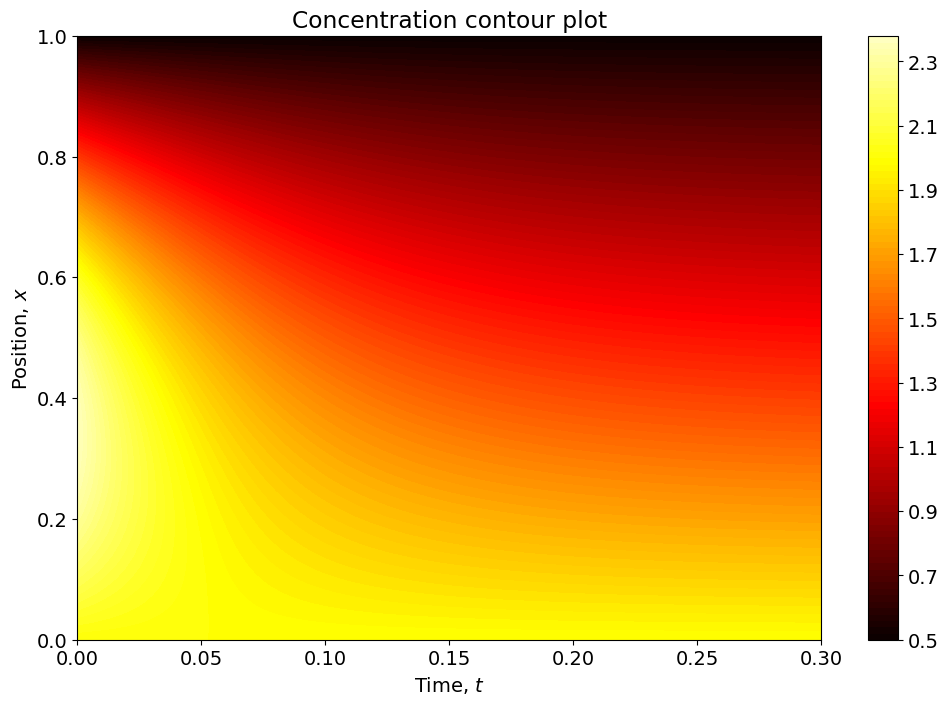

In [3]:
# Define the initial condition function
def ic(x):
    return 2 - 1.5*x + np.sin(pi*x)

# Create an empty class to contain our parameters
class params:
    pass

par = params()
par.xmin = 0
par.xmax = 1
par.T = 0.3
par.D = np.sqrt(2)
par.ul = 2
par.ur = 0.5
par.Nx = 51
par.Nt = 201
par.f = ic

# Solve the problem with finite differences 
xs,ts,us=diffusion_cranknicolson_dirichlet(par)

# Plot the solution
fig, ax = plt.subplots()
T, X = np.meshgrid(ts, xs)
c = plt.contourf(T, X, us, 100, cmap ="hot",vmin=0.5, vmax=2.5)
  
cbar = plt.colorbar(c)

ax.set_title('Concentration contour plot')
ax.set_ylabel(r'Position, $x$')
ax.set_xlabel(r'Time, $t$')

plt.show()

Let us plot the solution slightly differently to visualize better the convergence to steady-state. 

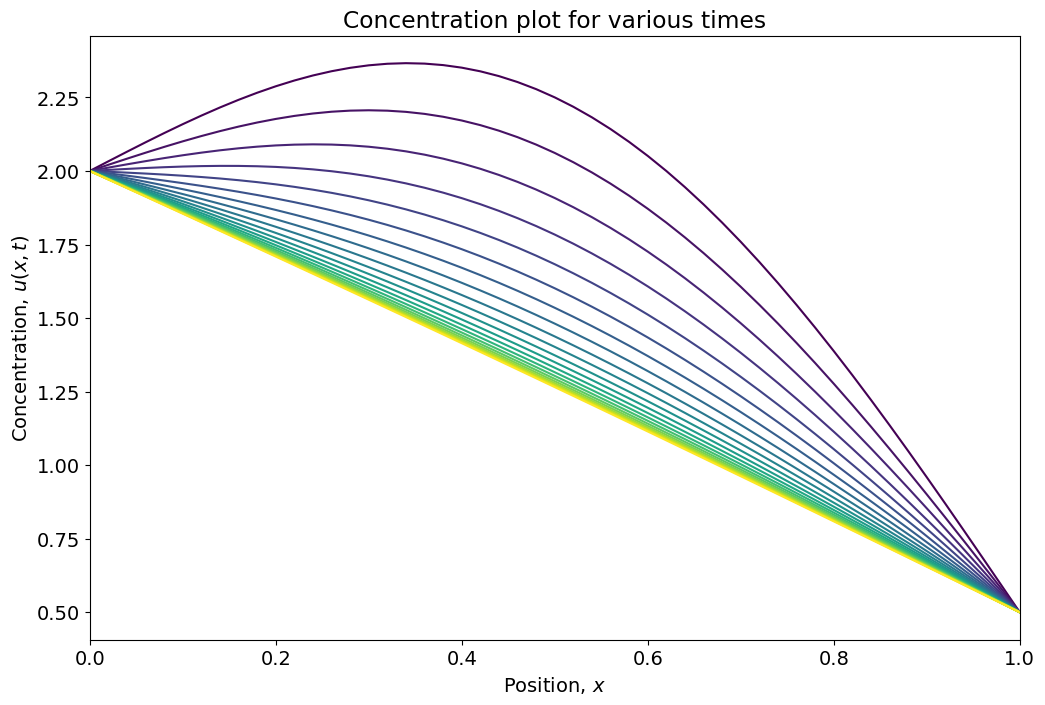

In [4]:
# Plot the solution
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis',len(ts))

for n in range(0,len(ts),10):
    plt.plot(xs,us[:,n],color=cmap(n))
    
ax.set_title('Concentration plot for various times')
ax.set_ylabel(r'Concentration, $u(x,t)$')
ax.set_xlabel(r'Position, $x$')
ax.set_xlim((0,1))

plt.show()

In this figure, the solution is represented as a function of time (with time increasing from blue to yellow). Note that the solution converges to the expected steady-state which is given by $U(x) = u_L + \frac{(u_R-u_L)}{L} x$.